# Base Notebook - Assignment 2

Assignment done by:

- Ahumada, Santiago | github: @santiagoahl

- Mora, David | github: @DavidFM43

## Table of contents

>[Base Notebook - Assignment 2](#scrollTo=d9W15eGi4xlx)

>>[Table of contents](#scrollTo=LdRUd7iE6oAY)

>[Imports](#scrollTo=dtqAueu_yrO4)

>[1st Point: Modeling a SVM](#scrollTo=WtHdqyPC5BDr)

>>[a) Build training and test data sets](#scrollTo=Agr8xWiA64FB)

>>[b) Implement different string kernels](#scrollTo=wR1IiTNV7NBU)

>>>[i) Histogram cosine kernel](#scrollTo=pHJkf1ZM7RaA)

>>>[ii) Histogram intersection kernel](#scrollTo=c-Smw5Am7dUn)

>>>[iii) $\chi^2$ kernel](#scrollTo=t9Pc5ZKp7ddH)

>>>[iv) SSK kernel](#scrollTo=FD8U-ccE7g6z)

>>[c) Train different SVMs](#scrollTo=CNqo7tA_AMrs)

>>[d) SVMs' performance](#scrollTo=ioWwO1E5ATsU)

>[2nd Pont: Digit Recognition model](#scrollTo=HAvZuftq5JSS)

>>[a) MNIST data import](#scrollTo=Z7d5wTz7ApQ3)

>>[b) Feature normalization](#scrollTo=TeqgkH8AAtUY)

>>[c) Hyperparameter optimization](#scrollTo=-YrJ_NJGAxFN)

>>[d) SVM's Weights](#scrollTo=zVA9Pmw6A1Hj)

>>[e) Plot discriminant function's weights](#scrollTo=DqnOtVuWBHN4)

>>>>[i) Weights arranging](#scrollTo=AVjTLTo-BO85)

>>>[ii) Matrix color plot](#scrollTo=KUtTAdocBR46)

>>>[iii) Matrix diverging colormap](#scrollTo=WDiY2-COBUnE)

>>>[iv) Discussion](#scrollTo=O0nI5EvtBWaB)

>>[f) Experiment: Digit pairs vs $C$ parameter](#scrollTo=SYyxe38KBrKF)

>[3rd Point:  Kernel logistic regression](#scrollTo=ZIJlAlU45YPo)

>>>[3.a) Discriminant function in terms of kernel and coefficients](#scrollTo=ogOJSQ4TCGH1)

>>>[3.b) Optimization problem approach](#scrollTo=EA2KsOv0CKhc)

>>>[3.c) Optimization algorithm](#scrollTo=byryeHyNCKnZ)

>>>[3.d) Algorithm testing & Decision reg](#scrollTo=9n0FOnSrCKvH)



# Setup

In [1]:
# Library import

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numba

import pandas as pd

from sklearn.datasets import fetch_openml, make_moons, make_circles, make_classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics.pairwise import cosine_similarity, chi2_kernel
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC, LinearSVC

import itertools
from random import sample
from wordcloud import WordCloud

sns.set(style="darkgrid", palette="deep", font_scale=1)

%load_ext Cython

# **1st Point: Modeling a SVM**

In this exercise, we're going to train an SVM capable to detect whether a word belongs to English or Spanish.

## **1.a) Build training and test data sets**

At the beginning of our project, we needed a dataset that included both English and Spanish words. We found the solution by referring to the Wiktionary frequency lists (http://en.wiktionary.org/wiki/Wiktionary:Frequency_lists) and extracting the most frequent words that were at least 4 characters long, ignoring accents. With this dataset in hand, we proceeded to the next step of our mission, which was to train a model that could effectively distinguish between English and Spanish words.

In [2]:
# Download the datasets
!wget https://raw.githubusercontent.com/DavidFM43/ml-course/main/assigment2/words_en.txt -q -nc
!wget https://raw.githubusercontent.com/DavidFM43/ml-course/main/assigment2/words_es.txt -q -nc

words_en = open("words_en.txt", "r").read().split("\n")[:-1]
words_es = open("words_es.txt", "r").read().split("\n")[:-1]
n_words_en, n_words_es = len(words_en), len(words_es)

In [3]:
# Final dataset
X = words_es + words_en
y = np.concatenate([np.ones(n_words_es), -np.ones(n_words_en)])

In [4]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## **1.b) Implement different string kernels**

We continued on our journey towards detecting between English and Spanish words. However, we encountered a challenge along the way: implementing different string kernels. Undaunted, we set to work exploring and experimenting with various string kernels, determined to find the one that would yield the most accurate results. Then, we were able to successfully implement multiple string kernels, paving the way towards a more refined and precise model.

### **1.b.i) Histogram cosine kernel**



To further enhance their model, we employed the histogram cosine kernel technique. By calculating a bag of n-grams representation and using CountVectorizer and cosine_similarity from scikit-learn, they were able to generate more accurate results and bring them one step closer to their goal.

In [5]:
def str_cosine_kernel(strings1, strings2, max_substring, use_first_vocab=True):
    # transform to bag of ngrams representation
    vectorizer = CountVectorizer(
        analyzer="char",
        ngram_range=(1, max_substring),
        strip_accents="ascii",
        lowercase=True,
    )
    # infers the vocab from strings1, this is useful to avoid train/test leakeage
    if use_first_vocab:
        vectorizer.fit(strings1)
    else:
        vectorizer.fit(strings1 + strings2)
    ngrams1 = vectorizer.transform(strings1).toarray()
    ngrams2 = vectorizer.transform(strings2).toarray()
    # apply cosine kernel
    kernel_matrix = cosine_similarity(ngrams1, ngrams2)
    return kernel_matrix

### **1.b.ii) Histogram intersection kernel**



With the goal of improving our model, we incorporated the histogram intersection technique by normalizing the bag of n-grams representation and calculating the sum of the minimum for each bin. This resulted in a more precise and dependable model.

In [6]:
@numba.jit(nopython=True)  # Decorator to enable JIT compilation with nopython mode
def intersection_kernel(A, B):
    """Normalize the samples and calculate the sum of the minimum for each feacture"""
    n, m = A.shape[0], B.shape[0]  # Take the input dimensions
    res = np.zeros((n, m), A.dtype)
    #  Loop over the all pairs of samples in parallel using Numba's prange
    for i in numba.prange(n):
        for j in numba.prange(m):
            res[i, j] = np.minimum(
                A[i], B[j]
            ).sum()  # calculate the histogram intersection
    return res

In [7]:
def str_intersection_kernel(strings1, strings2, max_substring, use_first_vocab=True):
    # transform to bag of ngrams representation
    vectorizer = CountVectorizer(
        analyzer="char",
        ngram_range=(1, max_substring),
        strip_accents="ascii",
        lowercase=True,
    )
    # infers the vocab from strings1, this is useful to avoid train/test leakeage
    if use_first_vocab:
        vectorizer.fit(strings1)
    else:
        vectorizer.fit(strings1 + strings2)
    ngrams1 = vectorizer.transform(strings1).toarray()
    ngrams2 = vectorizer.transform(strings2).toarray()
    # normalize
    ngrams1 = ngrams1 / ngrams1.sum(axis=1, keepdims=True)
    ngrams2 = ngrams2 / ngrams2.sum(axis=1, keepdims=True)
    # apply histogram intersection kernel
    kernel_matrix = intersection_kernel(ngrams1, ngrams2)
    return kernel_matrix

### **1.b.iii) $\chi^2$ kernel**



We tackled the $\chi^2$ kernel challenge by applying the `chi2_kernel` from `scikit-learn` to a bag of n-grams representation.

In [8]:
def str_chi2_kernel(strings1, strings2, max_substring, use_first_vocab=True):
    # transform to bag of ngrams representation
    vectorizer = CountVectorizer(
        analyzer="char",
        ngram_range=(1, max_substring),
        strip_accents="ascii",
        lowercase=True,
    )
    # infers the vocab from strings1, this is useful to avoid train/test leakeage
    if use_first_vocab:
        vectorizer.fit(strings1)
    else:
        vectorizer.fit(strings1 + strings2)
    ngrams1 = vectorizer.transform(strings1).toarray()
    ngrams2 = vectorizer.transform(strings2).toarray()
    # apply chi-squared intersection kernel
    kernel_matrix = chi2_kernel(ngrams1, ngrams2)
    return kernel_matrix

### **1.b.iv) SSK kernel**



With our goal in mind, we delved into the SSK kernel and utilized the available code from the helq/python-ssk repository to enhance our model.

In [9]:
%%cython

import numpy as np
cimport numpy as np

from cpython cimport array
import array

cimport cython

def ssk(s, t, int n, float lbda, accum=False):
    """s and t are strings, either numpy.str_ or python str, or a list of chars"""
    s_array = array.array('l', [ord(c) for c in s])
    t_array = array.array('l', [ord(c) for c in t])
    return ssk_array(s_array, t_array, n, lbda, accum)

# Kernel defined by Lodhi et al. (2002)
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def ssk_array(array.array s_, array.array t_, int n, float lbda, accum=False):
    cdef int lens, lent
    cdef int i, sj, tk
    cdef float toret
    cdef long[:] s # this reduces the overhead 10x fold!!!
    cdef long[:] t

    s = s_ if s_.typecode == 'l' else array.array('l', [int(c) for c in s_])
    t = t_ if t_.typecode == 'l' else array.array('l', [int(c) for c in t_])

    lens, lent = len(s), len(t)
    #k_prim = (-1)*np.ones( (n+1, lens, lent) )
    cdef np.ndarray[np.float64_t, ndim=3] \
        k_prim = np.zeros((n, lens, lent), dtype=float)

    k_prim[0,:,:] = 1

    for i in range(1,n):
        for sj in range(i,lens):
            toret = 0.
            for tk in range(i,lent):
                if s[sj-1]==t[tk-1]: # trick taken from shogun implemantion of SSK
                    toret = lbda * (toret + lbda*k_prim[i-1,sj-1,tk-1])
                else:
                    toret *= lbda
                k_prim[i,sj,tk] = toret + lbda * k_prim[i, sj-1, tk]

    cdef int start = 0 if accum else n-1
    cdef float k = 0.

    for i in range(n):
        for sj in range(i,lens):
            for tk in range(i,lent):
                if s[sj]==t[tk]:
                    k += lbda*lbda*k_prim[i,sj,tk]

    # print( [len(list(i for (sj,tk,i) in k_prim if i==m-1)) for m in range(n)] )
    return k

def string_kernel(xs, ys, n, lbda):
    """xs and ys are numpy arrays of strings or arrays of ints, n an integer and lbda a bool"""
    if len(xs.shape) != 2 or len(ys.shape) != 2 or xs.shape[1] != 1 or ys.shape[1] != 1:
        raise "The shape of the features is wrong, it must be (n,1)"

    cdef int lenxs, lenys
    cdef int i, j
    cdef np.ndarray[np.float64_t, ndim=2] mat, mat_xs, mat_ys
    lenxs, lenys = xs.shape[0], ys.shape[0]

    mat = np.zeros((lenxs, lenys))

    ssk_fun = ssk_array if xs.dtype == 'O' and isinstance(xs[0,0], array.array) else ssk

    # If both lists are equal, then the resulting matrix is symetric, there is no need to
    # calculate the hole thing
    if lenxs == lenys and np.array_equal(xs, ys):
        for i in range(lenxs):
            for j in range(i,lenys):
                mat[j,i] = mat[i,j] = ssk_fun(xs[i,0], ys[j,0], n, lbda, accum=True)

        mat_xs = mat_ys = mat.diagonal().reshape((lenxs, 1))

    else:
        for i in range(lenxs):
            for j in range(lenys):
                mat[i,j] = ssk_fun(xs[i,0], ys[j,0], n, lbda, accum=True)

        mat_xs = np.zeros((lenxs, 1))
        mat_ys = np.zeros((lenys, 1))

        for i in range(lenxs):
            mat_xs[i] = ssk_fun(xs[i,0], xs[i,0], n, lbda, accum=True)
        for j in range(lenys):
            mat_ys[j] = ssk_fun(ys[j,0], ys[j,0], n, lbda, accum=True)

    return np.divide(mat, np.sqrt(mat_ys.T * mat_xs))

In [10]:
def str_ssk_kernel(strings1, strings2, max_substring, lambda_decay=0.8):
    # transform to bag of ngrams representation
    l = np.array(strings1).reshape((len(strings1), 1))
    r = np.array(strings2).reshape((len(strings2), 1))

    return string_kernel(l, r, max_substring, lambda_decay)

## **1.c) Train different SVMs**

We continued our journey to detect between English and Spanish words. We trained various SVMs with precomputed kernels using scikit-learn, and performed cross-validation to find optimal regularization parameters. Experimenting with different n-gram configurations, we plotted the training and validation error vs. regularization parameter, using a logarithmic scale for C. Our careful analysis and experimentation helped us refine our model, ultimately achieving greater accuracy.

In [11]:
def optimize_kernel_parameters(string_kernel, X, y, max_substring=3):
    """
    Searchs for the best C and max_substring hyperparameters for a given
    string kernel and train data.
    """
    # regularization parameter C
    cs = [2**k for k in range(-15, 11)]
    # max_substring
    ns = range(1, max_substring + 1)
    results = pd.DataFrame(
        columns=["train", "val"],
        index=pd.MultiIndex.from_product([ns, cs], names=["max_substring", "c"]),
    )
    for n in ns:
        kernel_matrix = string_kernel(X, X, n)
        for c in cs:
            svm = SVC(kernel="precomputed", C=c)
            cv_results = cross_validate(
                svm,
                kernel_matrix,
                y,
                cv=5,
                return_train_score=True,
                error_score="raise",
                scoring="accuracy",
            )
            train_error = 1 - cv_results["train_score"].mean()
            val_error = 1 - cv_results["test_score"].mean()
            results.loc[n, c] = [train_error, val_error]
    return results


def plot_optimization_results(results, kernel_name):
    """Plots the train and validation error vs the C hyperparameter for each max_substring."""

    cs = [2**k for k in range(-15, 11)]
    max_substring = results.index.levels[0].max()
    _, axs = plt.subplots(1, max_substring, sharey=True, figsize=(15, 5))
    for idx in range(max_substring):
        tr, val = results.loc[idx + 1]["train"], results.loc[idx + 1]["val"]
        axs[idx].semilogx(cs, tr, base=2, label="Train Error")
        axs[idx].semilogx(cs, val, base=2, label="Validation Error")
        axs[idx].set_title(f"Cosine {kernel_name} with {idx+1}-max_substring")
        axs[idx].set_xlabel("C parameter")
    axs[0].legend()
    axs[0].set_ylabel("Error rate")
    plt.plot()

In [12]:
# maps kernel names to kernel functions
kernels = {
    "cosine": str_cosine_kernel,
    "hist_intersection": str_intersection_kernel,
    "chi_squared": str_chi2_kernel,
    "ssk": str_ssk_kernel,
}

best_params = dict()

CPU times: user 2min 9s, sys: 4.99 s, total: 2min 14s
Wall time: 2min 13s


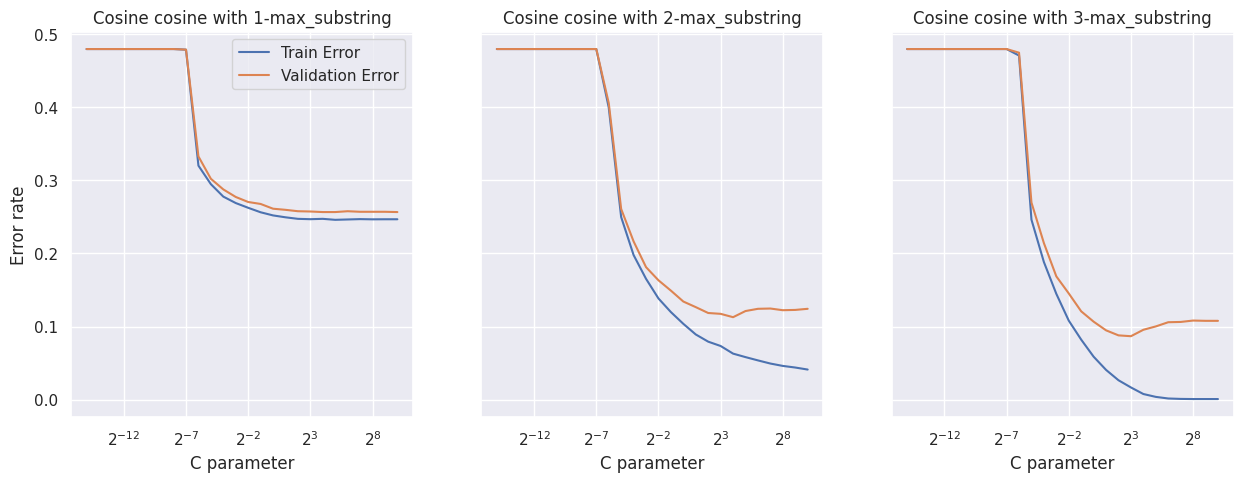

In [13]:
%%time
cosine_kernel_results = optimize_kernel_parameters(kernels["cosine"], X_train, y_train)
plot_optimization_results(cosine_kernel_results, "cosine")

From the previous graphs, we observe that our selection for the best $C$ parameter for the cosine kernel is $C=2^{3}$. Of course, we could select any other greater value in the sense that the curve doesn't actually change from that value. But, we discussed that selecting the smallest value in order to reduce the unnecesary extra computation of too small floats.

In [14]:
best_params["cosine"] = {"C": 2**3, "max_substring": 3}

CPU times: user 3min 33s, sys: 3.66 s, total: 3min 37s
Wall time: 3min 37s


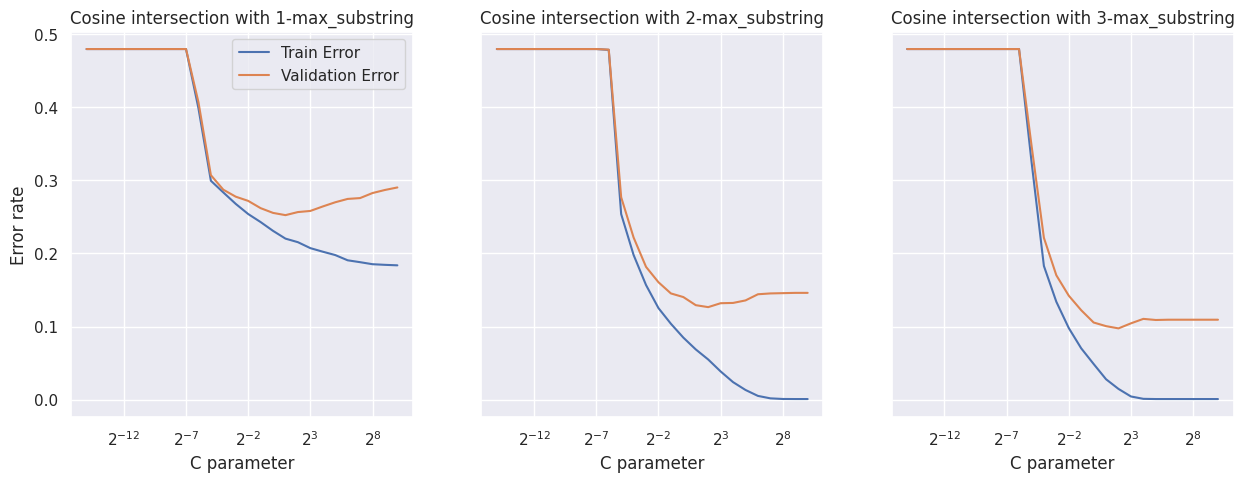

In [15]:
%%time
intersection_kernel_results = optimize_kernel_parameters(
    kernels["hist_intersection"], X_train, y_train
)
plot_optimization_results(intersection_kernel_results, "intersection")

By an analogous way, our selection for the best C parameter in the intersection kernel is $C=2^{2}$ since it minimizes the validation error in the three graphs.

In [16]:
best_params["hist_intersection"] = {"C": 2**2, "max_substring": 3}

CPU times: user 1min 35s, sys: 3.24 s, total: 1min 38s
Wall time: 1min 38s


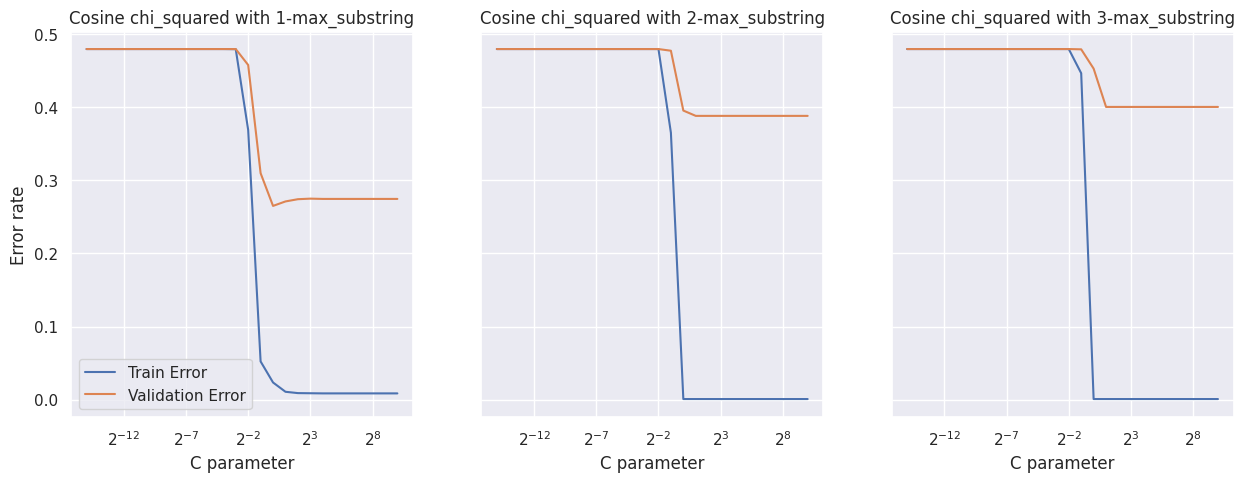

In [17]:
%%time
chi2_kernel_results = optimize_kernel_parameters(
    kernels["chi_squared"], X_train, y_train
)
plot_optimization_results(chi2_kernel_results, "chi_squared")

For the $\chi^2$ kernel, we observe that the best C parameter is $C=1.0$. But, in general, this kernel performs worst for this task.

In [18]:
best_params["chi_squared"] = {"C": 2**0, "max_substring": 1}

CPU times: user 3min 11s, sys: 4.93 s, total: 3min 16s
Wall time: 3min 16s


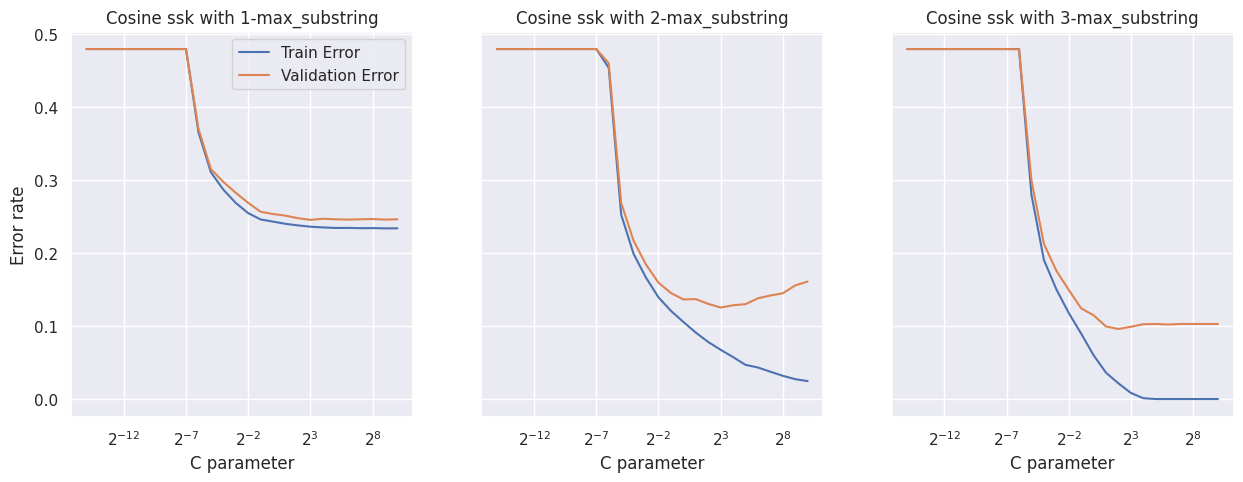

In [19]:
%%time
ssk_kernel_results = optimize_kernel_parameters(kernels["ssk"], X_train, y_train)
plot_optimization_results(ssk_kernel_results, "ssk")

Finally, for the SSK kernel, we chosen $C=2^2$ since it seems to be an optimal parameter for the three graphs

In [20]:
best_params["ssk"] = {"C": 2**2, "max_substring": 3}

## **1.d) SVMs' performance**

Our team's quest to classify English and Spanish words continued with the evaluation of our SVMs in the test dataset. We reported the results in a table and provided examples of errors, along with possible explanations. Finally, we discussed the results, offering insights and reflections on our model's performance.

In [21]:
%%time


def evaluate_svm(string_kernel, max_substring, C):
    """Evaluates a string kernel hyperparameters max_substring and C on the test dataset."""
    # precompute kernel matrices
    train_kernel = string_kernel(X_train, X_train, max_substring)
    test_kernel = string_kernel(X_train, X_test, max_substring)
    svm = SVC(kernel="precomputed", C=C)
    # fit classifier
    svm.fit(train_kernel, y_train)
    # for prediction the kernel matrix must have shape (test_samples, train_samples)
    y_pred = svm.predict(test_kernel.T)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


# dataframe with configurations and results
data = []
for name, fn in kernels.items():
    data.append(
        {
            "kernel_name": name,
            **best_params[name],
            "test_accuracy": evaluate_svm(fn, **best_params[name]),
        }
    )
results = pd.DataFrame(data)

CPU times: user 1min 58s, sys: 2.93 s, total: 2min 1s
Wall time: 1min 58s


In [22]:
results

,kernel_name,C,max_substring,test_accuracy
0,cosine,8,3,0.899197
1,hist_intersection,4,3,0.882248
2,chi_squared,1,1,0.716325
3,ssk,4,3,0.894737


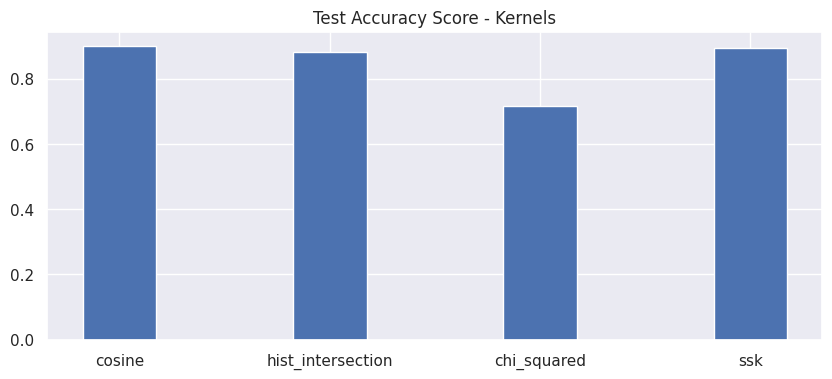

In [23]:
plt.figure(figsize=(10, 4))
plt.bar(x=results["kernel_name"], height=results["test_accuracy"], width=0.35)
plt.title("Test Accuracy Score - Kernels")
plt.show()

From the previous graphs, and the previous data frame view, we claim that the kernel that performs better is the cosine.

In [24]:
# now we are going to take a look at the missclassification of the best model
# first we train the model with the best hyperparams and predict on the test set
max_substring = best_params["cosine"]["max_substring"]
C = best_params["cosine"]["C"]

train_kernel = str_cosine_kernel(X_train, X_train, max_substring)
test_kernel = str_cosine_kernel(X_train, X_test, max_substring)

svm = SVC(kernel="precomputed", C=C)
svm.fit(train_kernel, y_train)

y_pred = svm.predict(test_kernel.T)

In [25]:
# identify the missclassified words
not_es_mask = (y_test != y_pred) & (y_pred == 1.0)
not_es = " ".join(np.array(X_test)[not_es_mask].tolist())

not_en_mask = (y_test != y_pred) & (y_pred == -1.0)
not_en = " ".join(np.array(X_test)[not_en_mask])

In [26]:
def plot_word_cloud(words, title):
    """Plots a word cloud from the words."""
    wordcloud = WordCloud(width=800, height=400, background_color="gray").generate(
        words
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

Let's visualize some missclassified words in both languages and try to inquire the possible reasons:

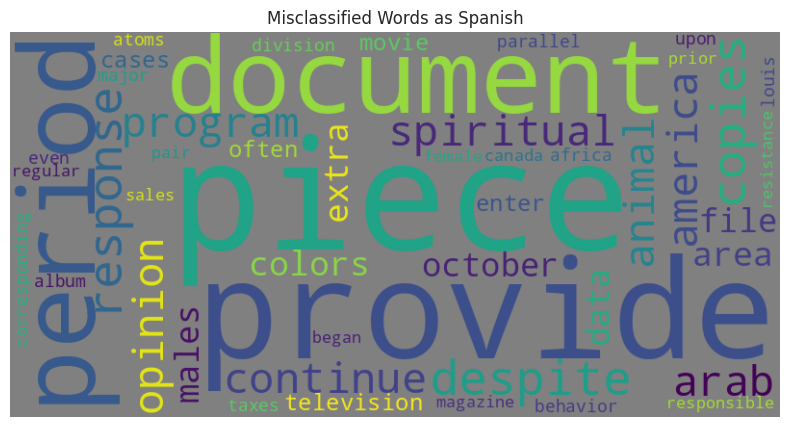

In [27]:
plot_word_cloud(not_es, "Misclassified Words as Spanish")

In the above visualization, we observe that there are some words that "works" in both english and spanish. For example animal, america, canada, continue and some others that are quite similar in both languages: period, spiritual, colors, and so on.

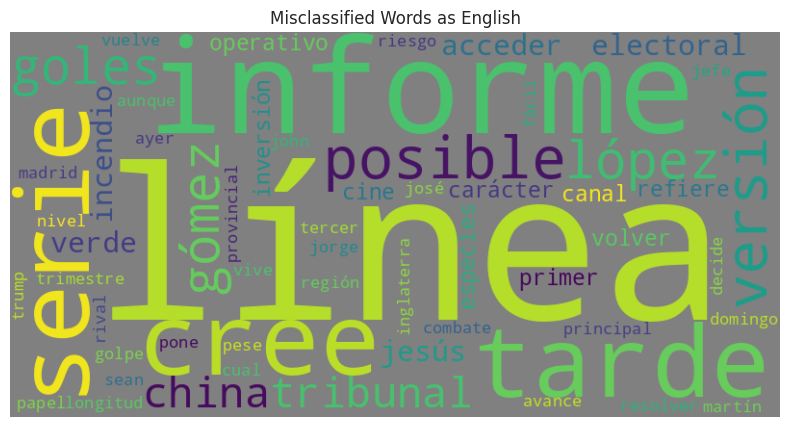

In [28]:
plot_word_cloud(not_en, "Misclassified Words as English")

By an analogous way, there are some ambiguous words that can be misclassified even by a human being e.g. version, serie, and so on.

# **2nd Pont: Digit Recognition model**

Now we're going to train an SVM in order to recognize pairs of digits from the MNIST dataset

## **2.a) MNIST data import**

We obtained the data for the MNIST dataset and explored it using the scikit-learn library.

In [29]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X_train, X_test, y_train, y_test = train_test_split(
    X.astype(np.float64),
    y.astype(np.float64),
    train_size=5000,
    test_size=1000,
    random_state=42,
)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## **2.b) Feature normalization**

Here, we normalize our features using the sklearn's standard scaler.

In [30]:
std_sc = StandardScaler()
X_train = std_sc.fit_transform(X_train)
X_test = std_sc.fit_transform(X_test)

## **2.c) Hyperparameter optimization**

Now train a linear SVM to discriminate between two classes and found the optimal complexity parameter C by plotting the training and test error vs. the regularization parameter on a logarithmic scale. 

In [31]:
def select_pair(pair, X_train, X_test, y_train, y_test):
    """
    Selects a pair of digits from MNIST dataset for binary classification.

    Given a pair of digits and the train/test datasets, selects only the samples corresponding to those digits for binary classification.

    Args:
        pair (tuple): A tuple of two integers representing the digits to be selected.
        X_train (ndarray): The training dataset.
        X_test (ndarray): The test dataset.
        y_train (ndarray): The labels of the training dataset.
        y_test (ndarray): The labels of the test dataset.

    Returns:
        tuple: A tuple containing the modified train and test datasets and labels.

    Example:
        >>> select_pair((1, 7), X_train, X_test, y_train, y_test)
        (X_train_selected, X_test_selected, y_train_selected, y_test_selected)
    """
    n1, n2 = pair
    mask_train = (y_train == n1) | (y_train == n2)
    mask_test = (y_test == n1) | (y_test == n2)
    X_train, y_train = X_train[mask_train], y_train[mask_train]
    X_test, y_test = X_test[mask_test], y_test[mask_test]
    return X_train, X_test, y_train, y_test

In [32]:
pair = (6, 7)
X_train_pair, X_test_pair, y_train_pair, y_test_pair = select_pair(
    pair, X_train, X_test, y_train, y_test
)

In [33]:
cs = [2**k for k in range(-15, 11)]
test_errors = []
train_errors = []

for c in cs:
    clf = LinearSVC(C=c, dual=True)
    clf.fit(X_train_pair, y_train_pair)
    y_pred_train = clf.predict(X_train_pair)  # Predict labels for the training set
    y_pred_test = clf.predict(X_test_pair)  # Predict labels for the test set

    # Compute and log metrics
    train_error = 1 - accuracy_score(y_train_pair, y_pred_train)
    test_error = 1 - accuracy_score(y_test_pair, y_pred_test)

    train_errors.append(train_error)
    test_errors.append(test_error)

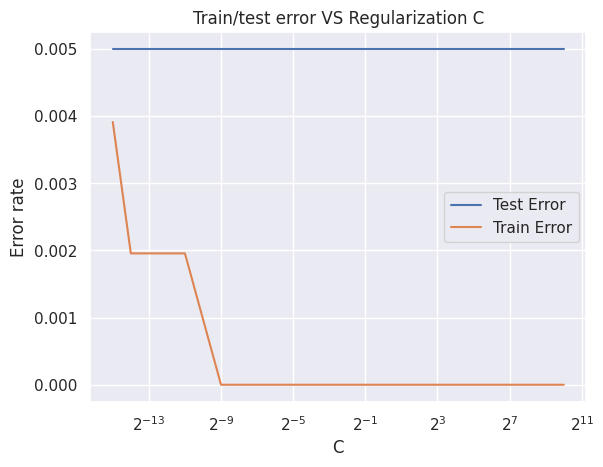

In [34]:
plt.semilogx(cs, test_errors, base=2, label="Test Error")
plt.semilogx(cs, train_errors, base=2, label="Train Error")
plt.xlabel("C")
plt.ylabel("Error rate")
plt.title("Train/test error VS Regularization C")
plt.legend()
plt.show()

In [35]:
c = 2**1
clf = LinearSVC(C=c)
clf.fit(X_train_pair, y_train_pair)
y_pred = clf.predict(X_test_pair)
test_error = 1 - accuracy_score(y_test_pair, y_pred)
print("The test error is: {}".format(test_error.round(3)))

The test error is: 0.005


Analysis: In the previous graph, we observed that the test error keeps smaller although the train one goes and goes to 0.

## **2.d) SVM's Weights**

We plotted the discriminant function weights by arranging them in a matrix with the same shape as the input image and using a function to produce a color plot of the matrix. We then used a diverging colormap to emphasize negative and positive values and analyzed and discussed the results.

In [36]:
weights = clf.coef_

## **2.e) Plot discriminant function's weights**

#### **2.e.i) Weights arranging**

To plot the discriminant function weights, we need to first arrange the weights in a matrix that has the same shape as the input image. This can be done by reshaping the weights array into a 2D matrix.

In [37]:
weights = weights.reshape(28, 28)

### **2.e.ii) Matrix color plot**

Once the weights have been arranged in a matrix, we can use the `colorbar` function to produce a color plot of the matrix:

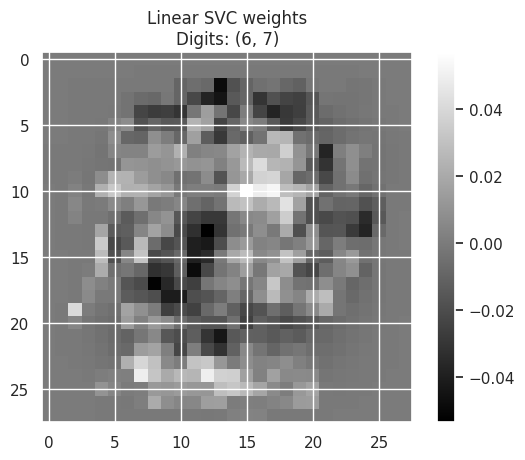

In [38]:
plt.imshow(weights, cmap="gray")
plt.title("Linear SVC weights\nDigits: {}".format(pair))
plt.colorbar()
plt.show()

### **2.e.iii) Matrix diverging colormap**

To emphasize the negative and positive values in the color plot, we can use diverging color maps. They have a clear midpoint that separates the positive and negative values, with distinct colors for each side. This helps to highlight the differences in the weights and make it easier to interpret the plot.

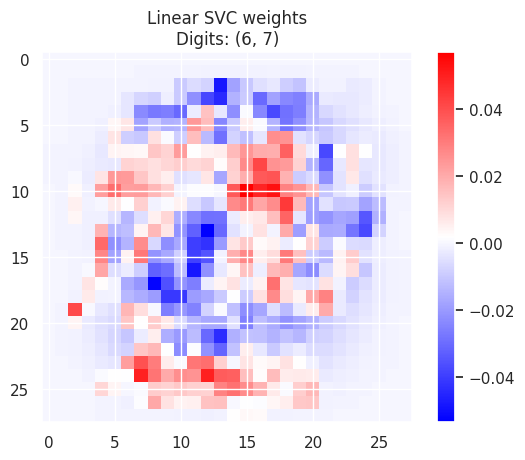

In [39]:
plt.imshow(weights.reshape(28, 28), cmap="bwr")
plt.title("Linear SVC weights\nDigits: {}".format(pair))
plt.colorbar()
plt.show()

### **2.e.iv) Discussion**

We've discussed on this problem and we think that the weights visualization seems, intuitively, a little interpretable. But we are actually surprised that the weights tends to form some regions (big "connected" red regions and blue regions). So, **We hypothesize that the weights will always tend to cluster themselfes into blue, and red regions**.

## **2.f) Experiment: Digit pairs vs $C$ parameter**

Here we're going to play with different pairs of digits and with different values for the $C$ parameter and observe how does the weights plot change.

In [40]:
# Select randomly a list of duples of digits
elements = range(1, 10)
combinations = list(itertools.combinations(elements, 2))

# Select 16 random pairs of digits from the list
chosen_pairs = sample(combinations, 16)

# Create a list of C parameter values to be tested
c_list_parameter = [2**k for k in range(-2, 4)]

In [41]:
def weights_svc(pair: tuple = (1, 2)) -> np.ndarray:
    """
    Trains a LinearSVC bivariate classifier for a fixed pair of digits and returns its weights as a matrix.

    Args:
        pair (tuple): Pair of digits used to train the classifier.

    Returns:
        numpy.ndarray: Weights of the classifier as a matrix which shape is (28, 28).

    Example:
        >>> pair = chosen_pairs[(4 * i) + j]  # get the pair of digits for the current subplot
        >>> weights = weights_svc(pair=pair)  # get the weights for the current pair of digits
        array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                ...
                ])
    """
    X_train_pair, X_test_pair, y_train_pair, y_test_pair = select_pair(
        pair, X_train, X_test, y_train, y_test
    )
    std_sc = StandardScaler()
    X_train_pair = std_sc.fit_transform(X_train_pair)
    X_test_pair = std_sc.fit_transform(X_test_pair)  # [ ] Change this
    svc = LinearSVC(C=0.2)
    svc.fit(X_train_pair, y_train_pair)
    y_pred = svc.predict(X_test_pair)
    weights = svc.coef_.reshape(28, 28)
    return weights

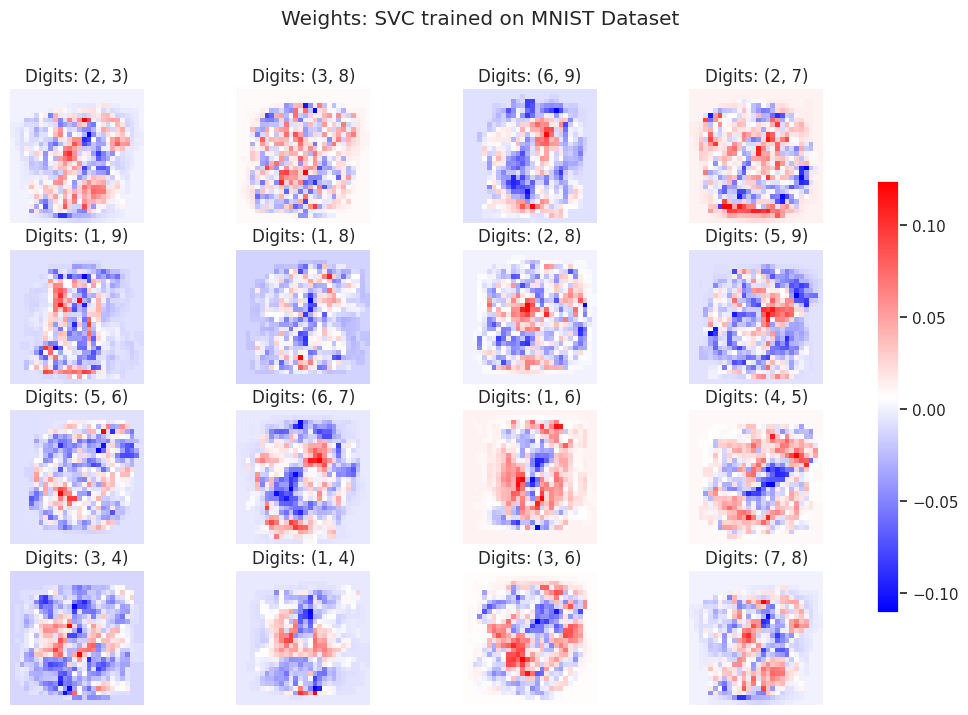

In [42]:
# Plot the discriminant function weights for some pair of digits

nrows = 4
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))

# Iterate through each subplot and plot the weights for the model trained on this pair
for i in range(nrows):
    for j in range(ncols):
        pair = chosen_pairs[
            (4 * i) + j
        ]  # get the pair of digits for the current subplot
        weights = weights_svc(
            pair=pair
        )  # get the weights for the current pair of digits
        ax[i, j].imshow(weights, cmap="bwr")  # plot the weights matrix
        ax[i, j].axis("off")  # remove the axis labels
        ax[i, j].set_title("Digits: {}".format(pair))  # set the title of the subplot

# Set the main title of the plot
fig.suptitle("Weights: SVC trained on MNIST Dataset")

# Add a colorbar to the plot
fig.colorbar(ax[0, 0].imshow(weights, cmap="bwr"), ax=ax, shrink=0.7)

# Show the plot
plt.show()

The previous plot tends to support our hypothesis (he weights will always **tend to cluster themselfes into blue, and red regions**). In fact, we aware of the lack of mathematical/scientific rigourosity of our hypothesis. However, We think that this first intuition may open a scietific method in order to find the truth.

# 3rd Point:  Kernel logistic regression

We will implement a kernel version of logistic regression. The goal is to train a logistic regression model on a feature space $F$. Specifically, the discriminant function of the model is
given by:
$$
f(x) = P(C = 1|x) = \sigma(w\Phi_k(x)),
$$
where $\Phi_k : X \rightarrow F$ is a mapping function associated with a kernel function $k : X \times X \rightarrow R$ and $\sigma$ is the logistic function.
Assume that the weight vector $w$ is expressed as a linear combination of the training samples:
$$
w = \sum_{i=1}^N \alpha_i y_i \Phi_k(x_i)
$$


### 3.a) Discriminant function in terms of kernel and coefficients

Lets find a formula of $f(x)$ in terms of $\vec{\alpha} = (\alpha_1, \alpha_2, \cdots, \alpha_l)$ and the kernel function $k : X \times X \rightarrow \mathbb{R}$:

$$
\begin{aligned}
    f(x | \vec{\alpha}, k)=& \sigma(w_{\vec{\alpha}} \cdot\Phi_k(x)) \\
        =& \sigma(\big(\sum_{i=1}^l\alpha_i\Phi_k(x^{(i)})\big) \cdot\Phi_k(x))\\
    =& \sigma\big(\sum_{i=1}^l\alpha_i(\Phi_k(x^{(i)})\cdot\Phi_k(x))\big)\\
    =& \sigma\big(\sum_{i=1}^l\alpha_ik(x^{(i)}, x)\big)\\
    =& \sigma\big(\vec{\alpha}\cdot \vec{k}(x)\big)\\
\end{aligned}
$$
Where $\vec{k}(x):= (k(x^{(1)}, x), k(x^{(2)}, x),\cdots, k(x^{(l)}, x))$.

### 3.b) Optimization problem approach

Now we formulate the problem of learning the parameters of the model as an optimization problem that looks for the parameters $α_i$ that minimize a cross entropy loss function. Namely:

Let be $\vec{\alpha} = (\alpha_1, \alpha_2, \cdots, \alpha_l)$ the parameters of the model and $k : X \times X \rightarrow R$ the kernel function. Then, we claim, that the optimization problem is reduced to find $\vec{\alpha}^*\in\mathbb{R}^l$ such that

$$
\begin{aligned}
\vec{\alpha}^* = argmin_{\vec{\alpha}\in\mathbb{R}^l}J(\vec{\alpha}| X, y)
\end{aligned}
$$

Where $J(\vec{\alpha}| X, y)$ is the cost function for the parameter vector $\vec{\alpha}$ given input and output datasets $X, y$ . $J$ is defined from the cross entropy loss function $L$ since 

$$
\begin{aligned}
J(\vec{\alpha}| X, y) := \frac{1}{l}\sum_{i=1}^{l} L(f(x^{(i)}|\vec{\alpha}, k), y)
\end{aligned}
$$

Notice that for a model estimation $\hat{y}$ of a datapoint $x$, the cross entropy loss function is given by 

$$
\begin{aligned}
L(\hat{y}, y) := - \big(ylog(\hat{y}) + (1-y)log(1-\hat{y})\big)
\end{aligned}
$$

Summaryzing, we can define our optimization problem as follows:

$$
\begin{aligned}
\vec{\alpha}^* = argmin_{\vec{\alpha}\in\mathbb{R}^l}\frac{-1}{l}\sum_{i=1}^{l} \big(y^{(i)}log(f(x^{(i)}|\vec{\alpha}, k)) + (1-y^{(i)})log(1-f(x^{(i)}|\vec{\alpha}, k))\big)
\end{aligned}
$$

### 3.c) Optimization algorithm

In [43]:
class KernelLogisticRegression:
    def __init__(self, kernel_fn, random_state=42):
        self.rng = np.random.default_rng(random_state)
        self.kernel_fn = kernel_fn
        self.alpha = None
        self.X_fit = None
        self.train_loss = []

    def fit(self, X, y, step=0.01, epochs=100):
        """Fits the kernel logistic regression using gradient descent."""
        self.X_fit = X
        kernel_matrix = self.kernel_fn(X, X)
        alpha = self.rng.standard_normal(len(X))
        for n in range(epochs):
            # forward pass
            logits = kernel_matrix @ alpha
            probs = 1 / (1 + np.exp(-logits))
            # clip probs to avoid overlog in log fn
            l = np.clip(np.where(y == 1, probs, 1 - probs), 1e-6, 1 - 1e-6)
            nll = -np.log(l)
            loss = nll.mean()
            # backward pass
            dnll = -np.ones_like(nll) / len(nll)
            dl = 1 / l * dnll
            dprobs = np.where(y_train == 1, 1, -1) * dl
            dlogits = probs * (1 - probs) * dprobs
            dalpha = kernel_matrix.T @ dlogits
            # update params
            alpha = alpha - step * dalpha
            self.train_loss.append(loss.item())

        self.alpha = alpha

    def predict_proba(self, X):
        """Predicts the probabilities of the positive class."""
        kernel_matrix = self.kernel_fn(X, self.X_fit)
        logits = kernel_matrix @ self.alpha
        probs = 1 / (1 + np.exp(-logits))
        return probs

    def predict(self, X):
        """Predicts either 0 or 1."""
        probs = self.predict_proba(X)
        return np.where(probs > 0.5, 1, 0)

### 3.d) Algorithm testing & Decision reg

Finally, we are going to test our algorithm using different kernels (linear, polynomial, Gaussian, etc.) on synthetic 2D datasets from sklearn (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). Plot the decision regions and discuss the results:

In [44]:
def linear_kernel(X, Y):
    return X @ Y.T


def polynomial_kernel(X, Y, deg=3):
    return (X @ Y.T) ** deg


@numba.jit(nopython=True)  # Decorator to enable JIT compilation with nopython mode
def gaussian_kernel(X, Y, sigma=1):
    n, m = X.shape[0], Y.shape[0]  # Take the input dimensions
    res = np.zeros((n, m), X.dtype)
    #  Loop over the all pairs of samples in parallel using Numba's prange
    for i in numba.prange(n):
        for j in numba.prange(m):
            res[i, j] = np.exp(-((X[i] - Y[j]) ** 2).sum() / 2 * (sigma**2))
    return res

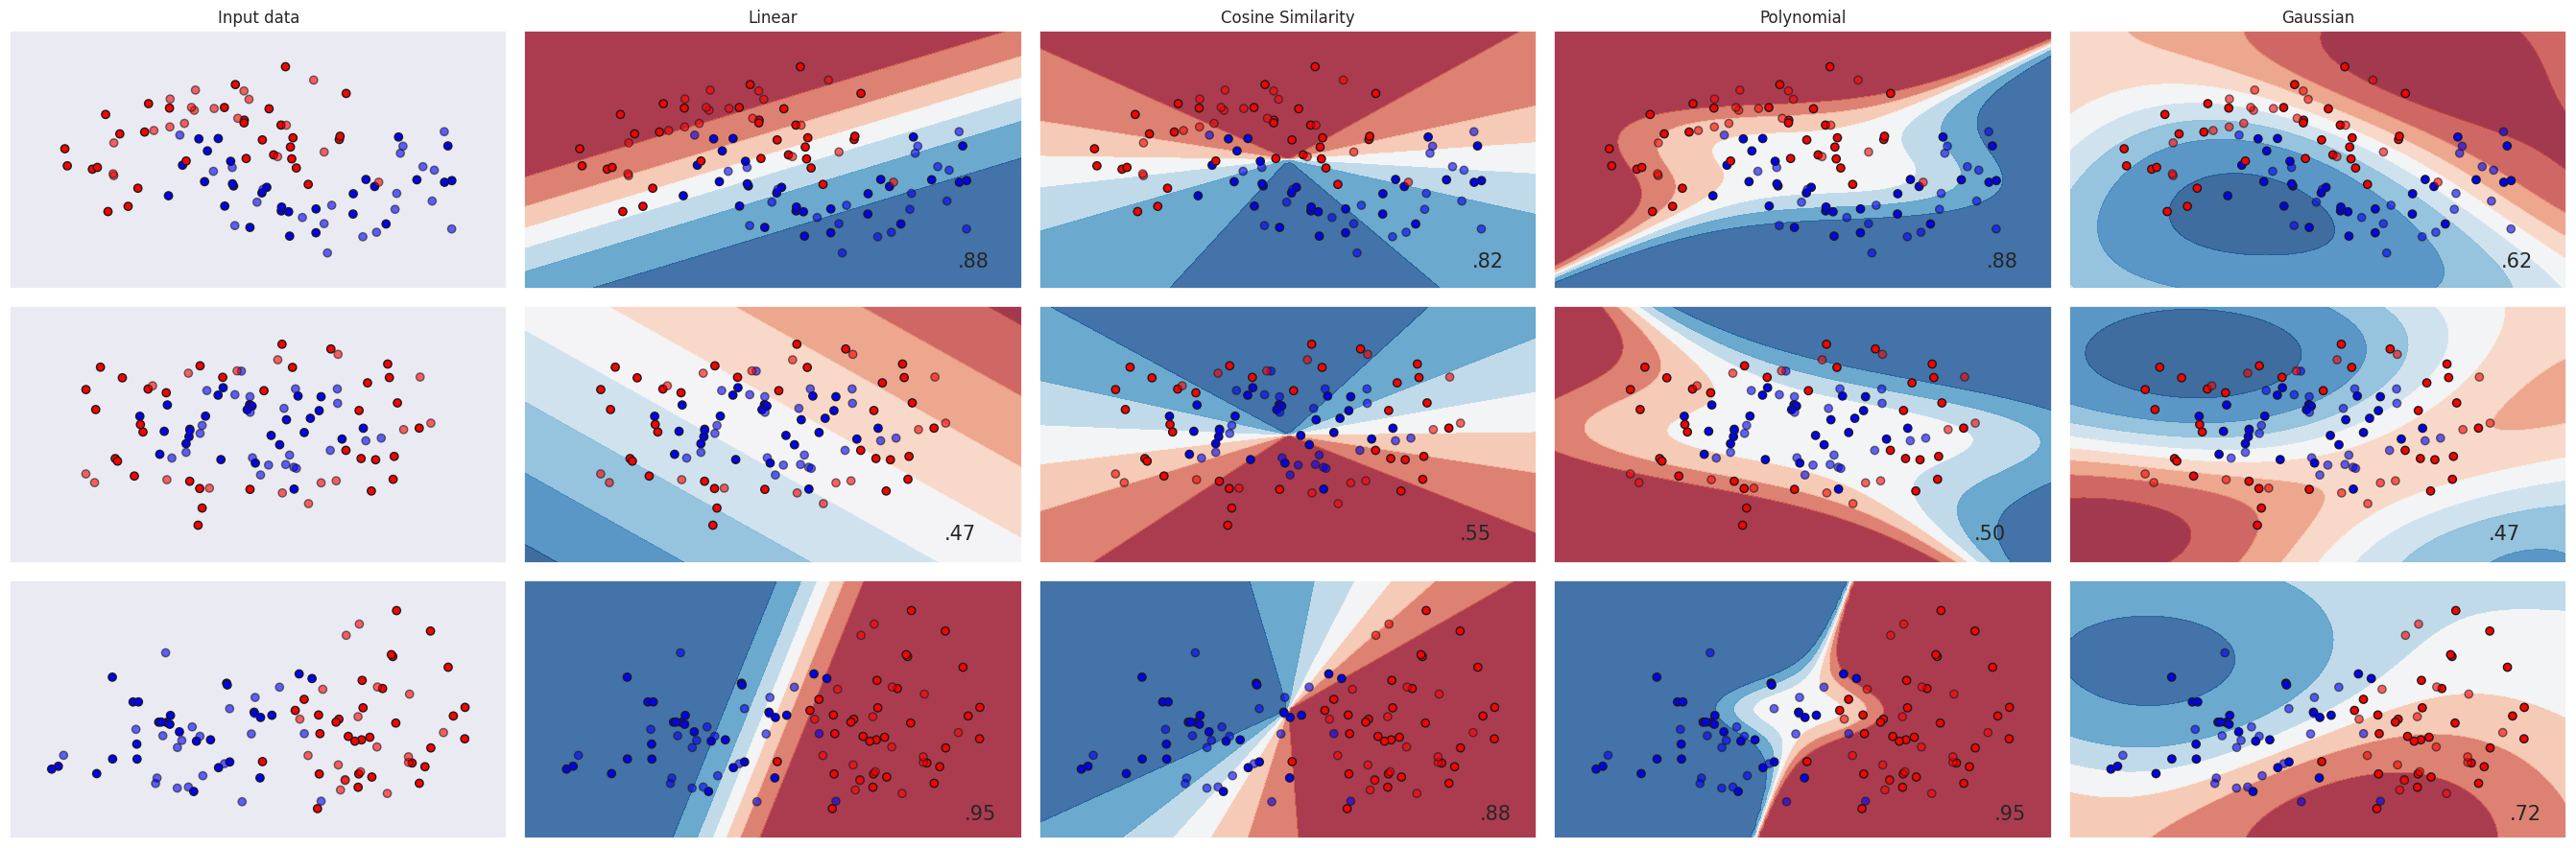

In [45]:
names = [
    "Linear",
    "Cosine Similarity",
    "Polynomial",
    "Gaussian",
]

kernel_fns = [
    linear_kernel,
    cosine_similarity,
    polynomial_kernel,
    gaussian_kernel,
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100),
    )
    X_grid = np.c_[xx.ravel(), yy.ravel()]

    # scale features
    std_sc = StandardScaler()
    X_train_sc = std_sc.fit_transform(X_train)
    X_test_sc = std_sc.fit_transform(X_test)
    X_grid_sc = std_sc.fit_transform(X_grid)

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(kernel_fns) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, kernel_fn in zip(names, kernel_fns):
        ax = plt.subplot(len(datasets), len(kernel_fns) + 1, i)

        clf = KernelLogisticRegression(kernel_fn)
        clf.fit(X_train_sc, y_train)
        response = clf.predict_proba(X_grid_sc).reshape(xx.shape)
        score = accuracy_score(y_test, clf.predict(X_test_sc))
        display = DecisionBoundaryDisplay(xx0=xx, xx1=yy, response=response)
        display.plot(ax=ax, plot_method="contourf", cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

From the previous graph, we observed that in each column (i.e. each kernel), We have similar shapes, and we observe how does those shapes fit themselves in order to classify the data points.